In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import warnings

data = """part_id,condition,allocation
A,Low,"3,1,0,2,1,0,0,0,1,2"
B,High,"0,0,2,0,2,0,1,2,0,3"
C,High,"3,0,0,2,1,0,0,0,3,1"
D,Low,"2,1,0,2,0,1,2,0,1,1"
E,Low,"3,2,0,0,0,1,0,3,0,1"
F,High,"0,0,2,0,0,1,2,0,2,3"
G,Low,"1,3,0,3,0,2,0,1,0,0"
H,High,"0,1,3,0,0,1,2,2,1,0"
I,High,"2,2,0,0,0,2,1,0,0,3"
J,Low,"1,3,1,0,2,2,0,0,0,1"
K,Low,"1,3,1,0,0,1,2,1,1,0"
L,Low,"3,1,2,1,0,1,0,1,0,1"
M,Low,"0,2,2,0,1,3,0,2,0,0"
N,Low,"1,3,0,2,0,1,1,1,1,0"
O,High,"0,0,1,3,1,0,0,3,0,2"
P,High,"1,1,2,0,0,0,2,0,2,2"
Q,High,"1,1,0,0,0,0,3,2,2,1"
R,High,"2,0,0,0,0,2,3,0,3,0"
S,High,"0,1,3,2,0,0,0,0,1,3"
T,Low,"1,3,1,0,1,0,3,0,0,1"
"""

You have just completed a pilot on a Qualtrics. Participants have been randomly assigned to one of two conditions ("Low" or "High"), and have learned a distribution of numbers ranging from 11 to 20.

After learning the distribution, they have been asked to predict the next 10 numbers drawn from this distribution. To do so, they had to allocate 10 balls on a distribution builder with 10 buckets, labeled [11, 12, 13, 14, 15, 16, 17, 18, 19, 20].

Here is the data for the first twenty participants in your study (in practice, always collect more than this. Please).

In [2]:
df = pd.read_csv(StringIO(data), sep=",")
df

,part_id,condition,allocation
0,A,Low,"3,1,0,2,1,0,0,0,1,2"
1,B,High,"0,0,2,0,2,0,1,2,0,3"
2,C,High,"3,0,0,2,1,0,0,0,3,1"
3,D,Low,"2,1,0,2,0,1,2,0,1,1"
4,E,Low,"3,2,0,0,0,1,0,3,0,1"
5,F,High,"0,0,2,0,0,1,2,0,2,3"
6,G,Low,"1,3,0,3,0,2,0,1,0,0"
7,H,High,"0,1,3,0,0,1,2,2,1,0"
8,I,High,"2,2,0,0,0,2,1,0,0,3"
9,J,Low,"1,3,1,0,2,2,0,0,0,1"


## 1. Data Wrangling: Transforming the data for statistical analysis and visualization.

If you look at the data, you can see that you have the allocation provided by each participant. 

However, those allocations are not interpretable right now:
1. The allocations are stored as a string (and not as a list of numbers).
2. This numbers in this *allocation* are not the values of the *distribution*: those are the number of balls in each bucket. You can see that all the values are below 10, while the buckets ranged from 11 to 20.

Let's review how you should transform this data, and what you can do with it.

The first step is to write a function and convert those allocations to distributions.

### a. Converting the allocations into distributions

In [3]:
def convert_allocation_to_distribution(allocation, buckets):
    """
    Takes an allocation of balls to buckets, and a list of buckets.
    Return the corresponding distribution of values.
    
    Example: 
        buckets = [1, 2, 3, 4, 5]
        x = "0, 3, 1, 2, 1"
        dist = convert_allocation_to_distribution(x, buckets)
        print(dist) -> (2, 2, 2, 3, 4, 4, 5)
    """
    arr = allocation.split(",")
    
    if len(arr) != len(buckets):
        raise ValueError("The number of buckets should match the length of the allocations.")
    values = np.repeat(buckets, arr)
    return values

Now we apply this function to the column "allocation", specifying that the buckets ranged from 11 to 20.

In [4]:
df["distribution"] = df["allocation"].apply(convert_allocation_to_distribution, 
                                            buckets=[11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
df.head()

,part_id,condition,allocation,distribution
0,A,Low,"3,1,0,2,1,0,0,0,1,2","[11, 11, 11, 12, 14, 14, 15, 19, 20, 20]"
1,B,High,"0,0,2,0,2,0,1,2,0,3","[13, 13, 15, 15, 17, 18, 18, 20, 20, 20]"
2,C,High,"3,0,0,2,1,0,0,0,3,1","[11, 11, 11, 14, 14, 15, 19, 19, 19, 20]"
3,D,Low,"2,1,0,2,0,1,2,0,1,1","[11, 11, 12, 14, 14, 16, 17, 17, 19, 20]"
4,E,Low,"3,2,0,0,0,1,0,3,0,1","[11, 11, 11, 12, 12, 16, 18, 18, 18, 20]"


Good! The raw allocation strings have now been converted to the actual distribution provided by participants. However, the data is in a nice shape: the data for each participant is stored as a list of number in a single column. Ideally, we'd like a format that we can use to do analysis and graphs.

### b. Pivoting the distributions in long form

We are now going to reshape the data in long form, such that one record corresponds to one value entered by one participant.

In [5]:
part_values = df.set_index('part_id')['distribution'].apply(pd.Series).stack().reset_index()
part_values.columns = ["part_id", "value_index", "value"]

Let's first check that we have the expected number of records. We have 20 participants and 10 values by participants:

In [6]:
part_values.shape[0]

200

That's a total of 200 observations. Good. Now if we inspect the head of the dataset...

In [7]:
part_values.head()

,part_id,value_index,value
0,A,0,11
1,A,1,11
2,A,2,11
3,A,3,12
4,A,4,14


...we see that we have lost some information along the way: we have the list of all values, but no longer have any participant-level information beyond the identifier `part_id`.

To correct this, we finally need to merge those values with the original dataset on the column `part_id`. 

### c. Merging back the rest of the data

Before merging, we can also drop the columns "distribution" and "allocation", which are no longer needed.

In [8]:
df_long = part_values.merge(df.drop(["distribution", "allocation"], axis=1), on="part_id")
df_long.head()

,part_id,value_index,value,condition
0,A,0,11,Low
1,A,1,11,Low
2,A,2,11,Low
3,A,3,12,Low
4,A,4,14,Low


We now have everything in long form:
* The participant-level information
* All the values of the distributions provided by the participants

We are now ready for some visualization and statistical analysis.

## 2. Visualizing the data

The first thing you can do is to inspect the distributions provided by the participants: do they look nice? Let's inspect the distributions provided by those 20 respondents.

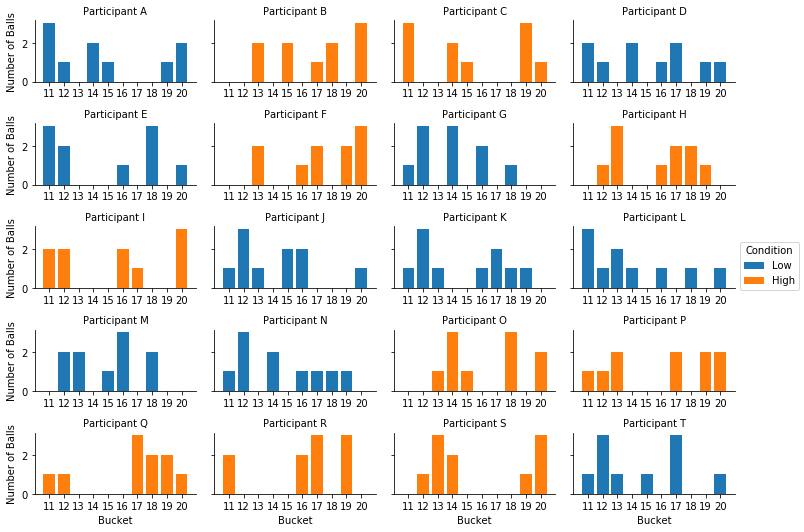

In [9]:
bins = np.arange(10.5, 20.6, 1)
xticks = np.arange(11, 20.1, 1)
g = sns.FacetGrid(data=df_long, col="part_id", col_wrap=4, hue="condition", sharex=False, size=1.5, aspect=1.7)
g.map(plt.hist, "value", bins=bins, histtype="bar", rwidth=0.8)
g.set_ylabels("Number of Balls")
g.set_xlabels("Bucket")
g.set(xticks=xticks)
g.set_titles("Participant {col_name}")
g.set(xlim=(10, 21))
g.add_legend(title="Condition");

Since those allocations were randomly generated, they do not look very nice. Oh well. But at least we have an interesting representation of participants' responses! 

Note that we could also look at the distribution of responses by condition.

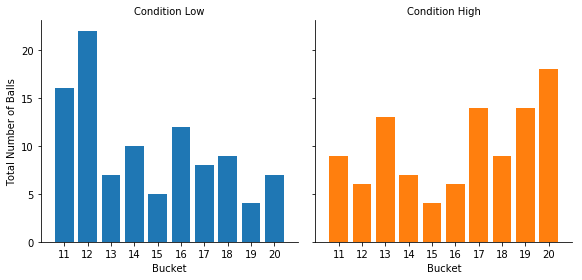

In [10]:
g = sns.FacetGrid(data=df_long, col="condition", hue="condition", size=4)
g.map(plt.hist, "value", bins=bins, lw=1, rwidth=0.8)
g.set_ylabels("Total Number of Balls")
g.set_xlabels("Bucket")
g.set(xticks=xticks)
g.set_titles("Condition {col_name}")
g.set(xlim=(10, 21));

The visualization above is informative within each condition, but you cannot compare the two conditions (unless you have the exact same number of participant in each condition).

If if is not the case, we can visualize the mean number of balls in each bucket and each condition by applying a simple transformation:

In [11]:
med_values = (df_long.groupby(["part_id", "value", "condition"]).count()
             .reset_index().groupby(["condition", "value"])
             .mean().reset_index())
med_values.columns = ["condition", "value", "median"]
med_values.head()

,condition,value,median
0,High,11,1.800000
1,High,12,1.200000
2,High,13,2.166667
3,High,14,2.333333
4,High,15,1.333333


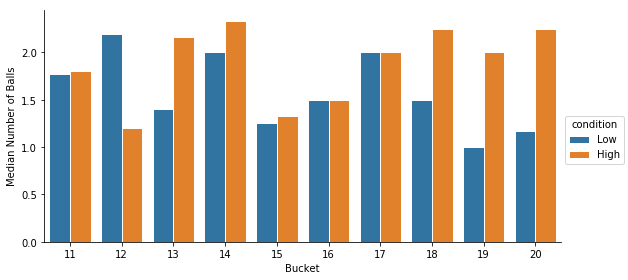

In [12]:
g = sns.factorplot(x="value", y="median", hue="condition", hue_order=["Low", "High"],
                   data=med_values, kind="bar", ec="white", size=4, aspect=2)
g.set_ylabels("Median Number of Balls")
g.set_xlabels("Bucket")
g.set_titles("Condition {col_name}");

## 3. Analyzing summary statistics

**The analysis of the data always depends on the research question.** 

So far, we have considered that we have collected 10 values from each participant, and have treated the data as such. 

However, we could have collected the data with the specific goal of testing people's perception of a statistics (e.g. mean/standard deviation/skewness) of a distribution. 

In that case, the relevant unit of analysis is the *statistics* computed at the distribution's level. We need to aggregate the long form data on `part_id`, and compute the statistics of interest, to obtain one record point per participant.

In [13]:
agg_values = df_long.groupby("part_id")["value"].aggregate(["mean","std", "skew"]).reset_index()
df_agg = agg_values.merge(df.drop(["allocation", "distribution"], axis=1), on="part_id")
df_agg.head()

,part_id,mean,std,skew,condition
0,A,14.7,3.713339,0.555959,Low
1,B,16.9,2.766867,-0.264377,High
2,C,15.3,3.683296,0.035688,High
3,D,15.1,3.212822,0.088451,Low
4,E,14.7,3.622461,0.197400,Low


We can now test the impact of our condition on people's perceived mean (or standard deviation, or skewness) of the distribution:

In [14]:
summ = smf.ols("mean~condition", data=df_agg).fit().summary()
summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     45.23
Date:                Fri, 13 Apr 2018   Prob (F-statistic):           2.64e-06
Time:                        17:12:36   Log-Likelihood:                -15.678
No. Observations:                  20   AIC:                             35.36
Df Residuals:                      18   BIC:                             37.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.2000      0.177     91.714      0.000      15.829      16.571
condition[T.Low]    -1.6800      0.250     -6.725      0.000      -2.205      -1.155
==============================================================================
Omnibus:                        0.287   Durbin-Watson:                   2.336
Prob(Omnibus):                  0.866   Jarque-Bera (JB):                0.395
Skew:                           0.235   Prob(JB):                        0.821
Kurtosis:                       2.498   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here, we see that participants in the "Low" condition reported a significantly lower mean that participants in the "High" condition (which is exactly how I created the data, so not so surprising...).

## 3. Wrapping up

I have demonstrated how to convert the raw data outputted by DistributionBuilder to a standard long form dataset. A few words of caution to finish:
* Always check that the list of buckets you use in the analysis matches the list of buckets that was shown to participants.
* Always check your number of records. If something is off, you might have missing data, or you might not have forced participants to submit a full distribution.
* Always ask yourself: what is my unit of analysis? Is it the values provided by participants, or is it a summary statistics of their total reported distribution.
